In [94]:
import pandas as pd
import numpy as np
import scipy

TODO:
- vykresleni data ze stromu a z vrtu dohromady s jinym tvarem 
- zobrazit dohromady data z vrtu a stromu + referencni body rek jako lini
- fixni meritko, spravna orientace otocit okolo Y souradnice
- interpolace pomoci P1 konecnych diferenci, natocit grid ve smeru pritokove reky
  odhad anisotropie podle Polaku
- Dostat od nekud Z data
- get elevation data from [Google](https://developers.google.com/maps/documentation/elevation/intro)


# Data input

Input data have a form of Excel tables with folowing structure:

- The first row contains column names which should be consistent between individual files. 
  Names are withou diacretics, prefered is English. See defined names further on.
- The second row is ignored, may conatin units.
- Data are placed from the third row further on.

## Definition of variables (columns)

### Common to wells and trees
- **latitude** - latitude in degrees
- **longitude** - longitude in degrees
- **surface altitude** - Terrain altitude at the head of the well.
- **JTSK x** - (optional) Krovak system, east axis
- **JTSK y** - (optional) Krovak system, north axis
- **A-HCH, ...** - concentrations of isomers A, B, C, D, E (Variable)
- **Sum-HCH** - sum of isomer concentrations (meningfull only for very small concentrations)

### Well variables
- **well name** - unique name of the well, same for different years
- **depth aquifer** - Depth from the surface to the ground of the aquifer.
- **depth water** - Depth from the surface to the water table. (Variable)
- **screen begin** - Depth from the surface to beginning of screening, perfored casing.
- **screen end** - Depth from the surface to end of screening, perfored casing.
- **priority**
- **notes**

### Tree variables
- **circumference** - circumference of the trunk, [cm]
- **specie** - tree specie, unique specie name
- **sample code** - label of the sample, unique within the table
- **previous code** - label of the sample from the same tree in previous year
- **matrix** - type of sample (try to avoid)





## Loading and merging wells tables

In [95]:
from jaworzno_tools import *
    
def read_wells(date):
    """
    :param date: Prefix of the file name to specify year and month of sampling.
    """
    df_common = read_table("../data_Hrabak/2017_wells.xlsx", unit_line=True)
    df_common = make_jtsk(df_common)
    #print(df_common)
    df_var = read_table("../data_Hrabak/{}_water_results.xlsx".format(date), unit_line=True)  
    df_var = pd.merge(df_common, df_var, on='well')
    #df_var.drop(['jtsk_x', 'jtsk_y'],)
    return df_var
    
wells_2017 = read_wells("2017_06")    
wells_2017.head(5)

,well,long,lat,alt,d_aquifer,d_water,s_begin,s_end,jtsk_x,jtsk_y,Sa,Sb,Sc,Sd,Se
0,P14,19.2446,50.1882,253.96,NaN,4.71,NaN,NaN,-398879.574921,-1.067976e+06,45.821256,5.852845,16.220755,18.399697,4.057764
1,P21,19.2429,50.1888,252.82,NaN,4.31,NaN,NaN,-398996.808096,-1.067900e+06,1.988654,18.944623,1.234564,1.398301,23.103841
2,P30,19.2339,50.1845,246.3,10.4,6.35,8.4,9.9,-399673.920639,-1.068330e+06,0.000000,0.731856,0.591902,1.005656,1.842693
3,P32,19.2464,50.188,254.6,9.2,5.2,7.2,8.7,-398757.390833,-1.068007e+06,25.923422,5.764643,15.177873,33.585947,6.377719
4,P33,19.2473,50.1879,253.7,10,4.45,8,9.5,-398695.942157,-1.068023e+06,47.168385,3.227954,79.180595,66.662339,14.550275


In [96]:
wells_2018 = read_wells("2018_06")    
wells_2018.head(5)

,well,long,lat,alt,d_aquifer,d_water,s_begin,s_end,jtsk_x,jtsk_y,Sa,Sb,Sc,Sd,Se
0,P21,19.2429,50.1888,252.82,NaN,4.31,NaN,NaN,-398996.808096,-1.067900e+06,0.720000,10.173333,0.906667,1.500000,9.500000
1,P30,19.2339,50.1845,246.3,10.4,6.35,8.4,9.9,-399673.920639,-1.068330e+06,0.313333,1.993333,0.146667,1.026667,4.126667
2,P32,19.2464,50.188,254.6,9.2,5.2,7.2,8.7,-398757.390833,-1.068007e+06,46.453333,13.326667,28.973333,85.633333,18.786667
3,P33,19.2473,50.1879,253.7,10,4.45,8,9.5,-398695.942157,-1.068023e+06,45.060000,1.420000,93.440000,59.273333,12.740000
4,P34,19.2467,50.1873,250.4,7.3,0.78,5.3,6.8,-398741.758376,-1.068086e+06,176.846667,5.753333,277.000000,3.600000,5.033333


## Differences between years

In [97]:
S_list = ['Sa', 'Sb', 'Sc', 'Sd', 'Se']
both_wells = pd.merge(wells_2017, wells_2018, on='well').well
w_17 = wells_2017.set_index('well')
w_18 = wells_2018.set_index('well')
S_2017 = w_17.loc[both_wells, S_list]
S_2018 = w_18.loc[both_wells, S_list]
S_2018 - S_2017
#both.loc[:, ]

,Sa,Sb,Sc,Sd,Se
well,,,,,
P21,-1.268654,-8.771290,-0.327898,0.101699,-13.603841
P30,0.313333,1.261477,-0.445235,0.021011,2.283973
P32,20.529912,7.562023,13.795461,52.047386,12.408947
P33,-2.108385,-1.807954,14.259405,-7.389005,-1.810275
P34,48.513806,-5.693748,91.831065,-59.638637,-3.956063
P35,-34.420887,-21.276454,-81.374959,-94.108657,-14.716792
P37,-0.284606,-0.992038,-0.203912,0.551467,0.479794
P38,0.253827,0.660148,0.226642,2.418060,0.690026
P39,-0.167144,0.081650,-0.148918,1.155558,4.227643


In [98]:
# Relative error
max_vals = pd.concat([S_2018, S_2017]).max(level=0)
(S_2018 - S_2017)/np.abs(max_vals)

,Sa,Sb,Sc,Sd,Se
well,,,,,
P21,-0.637946,-0.462996,-0.265598,0.067800,-0.588813
P30,1.000000,0.632848,-0.752211,0.020465,0.553467
P32,0.441947,0.567435,0.476143,0.607794,0.660519
P33,-0.044699,-0.560093,0.152605,-0.110842,-0.124415
P34,0.274327,-0.497397,0.331520,-0.943073,-0.440081
P35,-0.255555,-0.678968,-0.435242,-0.678626,-0.607710
P37,-0.692013,-0.719543,-0.496646,0.523545,0.666381
P38,0.551799,0.792177,0.373586,0.893372,0.814991
P39,-0.544188,0.583213,-0.452752,0.480149,0.798673


In [99]:
# Log error
np.log10(S_2018/S_2017)

,Sa,Sb,Sc,Sd,Se
well,,,,,
P21,-0.441227,-0.270023,-0.134066,0.030491,-0.385961
P30,inf,0.435154,-0.605918,0.008980,0.350146
P32,0.253325,0.363949,0.280788,0.406485,0.469184
P33,-0.019860,-0.356639,0.071914,-0.051021,-0.057702
P34,0.139259,-0.298775,0.174912,-1.244680,-0.251875
P35,-0.128167,-0.493452,-0.248137,-0.492989,-0.406393
P37,-0.511467,-0.552134,-0.298126,0.321978,0.476749
P38,0.348527,0.682307,0.203139,0.972129,0.732807
P39,-0.341214,0.380086,-0.261816,0.284121,0.696098


In [102]:
def plot_square_grid():
    lat_avg = np.mean(wells_2017.lat)
    long_avg = np.mean(wells_2017.long)
    map_options = GMapOptions(lat=lat_avg, lng=long_avg, map_type="roadmap", zoom=15)
    jaw_map = bkh.gmap(api_key, map_options, title="Jaworzno", sizing_mode='stretch_both')

    to_jtsk = pyproj.Proj(init='EPSG:5514')
    avg_x, avg_y = to_jtsk(long_avg, lat_avg)
    X, Y = np.meshgrid(np.linspace(avg_x, avg_x+100, 10), np.linspace(avg_y, avg_y+100, 10))
    ll = [ to_jtsk(x,y, inverse=True) for x,y in zip(X.flat,Y.flat)]
    long, lat = zip(*ll)
    source = ColumnDataSource(dict(lat=lat, long=long))

    jaw_map.circle(x="long", y="lat", size=3, 
                   fill_alpha=0.8, source=source)

    bkh.show(jaw_map)
    
#plot_square_grid()

In [103]:
import json
import urllib


ELEVATION_BASE_URL = 'https://maps.googleapis.com/maps/api/elevation/json'
CHART_BASE_URL = 'https://chart.apis.google.com/chart'

def getChart(chartData, chartDataScaling="-500,5000", chartType="lc",chartLabel="Elevation in Meters",chartSize="500x160",chartColor="orange", **chart_args):
    chart_args.update({
      'cht': chartType,
      'chs': chartSize,
      'chl': chartLabel,
      'chco': chartColor,
      'chds': chartDataScaling,
      'chxt': 'x,y',
      'chxr': '1,-500,5000'
    })

    dataString = 't:' + ','.join(str(x) for x in chartData)
    chart_args['chd'] = dataString.strip(',')

    chartUrl = CHART_BASE_URL + '?' + urllib.parse.urlencode(chart_args)

    print(chartUrl)

def getElevation(path="36.578581,-118.291994|36.23998,-116.83171",samples="100", **elvtn_args):
      elvtn_args.update({
        'path': path,
        'samples': samples
      })

      url = ELEVATION_BASE_URL + '?' + urllib.parse.urlencode(elvtn_args)
      response = json.load(urllib.request.urlopen(url))

      # Create a dictionary for each results[] object
      elevationArray = []

      for resultset in response['results']:
        elevationArray.append(resultset['elevation'])

      # Create the chart passing the array of elevation data
      getChart(chartData=elevationArray)

if __name__ == '__main__':
    # Mt. Whitney
    startStr = "36.578581,-118.291994"
    # Death Valley
    endStr = "36.23998,-116.83171"

    pathStr = startStr + "|" + endStr

    getElevation(pathStr)

https://chart.apis.google.com/chart?cht=lc&chs=500x160&chl=Elevation+in+Meters&chco=orange&chds=-500%2C5000&chxt=x%2Cy&chxr=1%2C-500%2C5000&chd=t%3A


## Loading and fixing Tree tables

In [138]:
from jaworzno_tools import *

def nonzero_HCH(df, min_hch=1e-6):
    # subsititute 0 concentrations with 1e-6 for log processing
    for col in ['Sa', 'Sb', 'Sc', 'Sd', 'Se']:
        df.loc[:, col] = np.maximum(min_hch, df.loc[:, col])
    return df    

def merge_species(df):        
    # specie manipulation
    # alder -> adler
    # red oak -> oak
    df.loc[df.specie=='oak ', 'specie'] = 'oak'
    df.loc[df.specie=='red oak', 'specie'] = 'oak'
    df.loc[df.specie=='adler', 'specie'] = 'alder'
    df.loc[df.specie=='forest pine', 'specie'] = 'pine'
    print(df.specie.unique())
    return df

    # Remove species with low count
    df = df[ np.isin(df.specie, ['linden', 'ash', 'maple'], invert=True)]
    df.specie.value_counts() 
    
def read_trees(date):    
    df_tree = read_table("../data_Hrabak/{}_tree_results.xlsx".format(date), unit_line=True)
    df_tree = make_jtsk(df_tree)
    
    df_tree = nonzero_HCH(df_tree, min_hch=1e-2)
    df_tree = merge_species(df_tree)
    df_tree['Ssum'] = np.sum(df_tree.loc[:,S_list], axis=1)

    return df_tree
                        
trees_2017 = read_trees("2017_06")
trees_2017.head(5)

['birch' 'pine' 'poplar' 'alder' 'oak' 'ash' 'linden' 'maple']


,sid,matrix,specie,cfrc,jtsk_x,jtsk_y,Sa,Sb,Sc,Sd,Se,long,lat,Ssum
1,001,wood,birch,103.0,-401255.315772,-1.067469e+06,0.01,0.01,0.01,0.01,0.01,1.000000e+30,1.000000e+30,0.05
2,002,wood,birch,167.0,-401257.580567,-1.067499e+06,0.01,0.01,0.01,0.01,0.01,1.000000e+30,1.000000e+30,0.05
3,003,wood,birch,98.0,-401275.103823,-1.067467e+06,0.01,0.01,0.01,0.01,0.01,1.000000e+30,1.000000e+30,0.05
4,004,wood,pine,94.0,-401273.179851,-1.067452e+06,0.01,0.01,0.01,0.01,0.01,1.000000e+30,1.000000e+30,0.05
5,005,wood,poplar,77.0,-401266.795194,-1.067489e+06,0.01,0.01,0.01,0.01,0.01,1.000000e+30,1.000000e+30,0.05


In [105]:
trees_2018 = read_trees("2018_06")
trees_2018.head(5)

['birch']


,sid,prev_id,lat,long,cfrc,specie,Sa,Sb,Sc,Sd,Se,jtsk_x,jtsk_y,Ssum
1,201,NaN,50.1748,19.2282,106.0,birch,0.000001,12.860000,0.000001,0.000001,0.000001,-400157.319737,-1.069376e+06,12.860004
2,202,NaN,50.1771,19.2312,90.0,birch,0.000001,0.000001,0.000001,0.000001,0.000001,-399925.283308,-1.069132e+06,0.000005
3,203,NaN,50.1796,19.2265,100.0,birch,0.000001,0.000001,0.000001,0.000001,0.000001,-400241.587994,-1.068834e+06,0.000005
4,204,NaN,50.1789,19.2244,101.0,birch,0.000001,0.000001,0.000001,0.000001,0.000001,-400395.789921,-1.068906e+06,0.000005
5,205,NaN,50.1783,19.2223,94.0,birch,0.000001,0.000001,0.000001,0.000001,0.000001,-400550.751234,-1.068958e+06,0.000005


In [136]:
from bokeh.io import output_file, output_notebook, show
from bokeh.models import (
    glyphs, LogTicker,
  GMapPlot, GMapOptions, ColumnDataSource, Circle, LogColorMapper, BasicTicker, ColorBar,
    DataRange1d, PanTool, WheelZoomTool, BoxSelectTool, HoverTool, LassoSelectTool, SaveTool

)
from bokeh.models.mappers import ColorMapper, LinearColorMapper
from bokeh.palettes import Viridis256, Plasma256
import bokeh.plotting as bkh


# No way to make plot inside the notebook!
## output_notebook()
#from bokeh.resources import INLINE
#bkh.output_notebook(resources=INLINE)

In [140]:
def make_gmap():
    
    lat_avg = np.mean(wells_2017.lat)
    long_avg = np.mean(wells_2017.long)
    # map_type = satellite, roadmap, terrain, hybrid
    map_options = GMapOptions(lat=lat_avg, lng=long_avg, map_type="roadmap", zoom=15)

    with open("API_key", "r") as f:
        api_key = f.read().strip()    

    gmap = bkh.gmap(api_key, map_options, title="Jaworzno", sizing_mode='stretch_both')
    hover = HoverTool(tooltips=[("well", "@well"), ("tree", "@sid")])
    gmap.add_tools(hover)
    gmap.add_tools(WheelZoomTool())
    gmap.add_tools(LassoSelectTool())
    gmap.add_tools(SaveTool())

    return gmap

def add_points(gmap, df, columns, pal, in_radius=0, out_radius=20):
    
    df_cp = df.copy()
    df_cp.columns = df.columns = df.columns.get_level_values(0)
    source = ColumnDataSource(df)
    y_max = max([np.max(df[col]) for col in columns])
    y_min = min([np.min(df[col]) for col in columns])
    mapper = LogColorMapper(palette=pal, low=y_min, high=y_max)
    
    for i, col in enumerate(columns):
        s_ang = 2 * np.pi * i / len(columns)
        e_ang = 2 * np.pi * (i + 1) / len(columns)
        gmap.annular_wedge(x="long", y="lat", 
                   inner_radius=in_radius, outer_radius=out_radius, 
                   start_angle=s_ang, end_angle=e_ang,
                   fill_color={'field': col, 'transform': mapper},
                   fill_alpha=0.8, 
                   line_width=0.1,
                   line_color='#FFFFFF',
                   source=source)

    color_bar = ColorBar(color_mapper=mapper, ticker=LogTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0))

    gmap.add_layout(color_bar, 'right')

def add_wells(gmap, df):
    add_points(gmap, df, S_list, Viridis256, in_radius=5, out_radius=30)

def add_trees(gmap, df):
    add_points(gmap, df, S_list, Plasma256) #, out_radius='cfrc')

    
gmap = make_gmap()
add_wells(gmap, wells_2018)
add_trees(gmap, trees_2018)
bkh.show(gmap)



In [106]:
def get_cols(df):
    if df.columns.nlevels < 2:
        return df.columns
    else:
        return df.columns.levels[0]
    
def closest(df, df_search, n_neigbbours):
    if df.columns.nlevels < 2:
        df.columns = pd.MultiIndex.from_product([df.columns,[0]])
    assert {'jtsk_x', 'jtsk_y'} <= set(get_cols(df))
    assert {'jtsk_x', 'jtsk_y'} <= set(get_cols(df_search))
    print(df.columns)
    df = df.drop(columns=['i_nb', 'nb_dist'], errors='ignore')
    print(df.columns)
    nb_dict = {}    
    for i, row in df.iterrows():           
        pw = np.array( (row['jtsk_x'], row['jtsk_y']), dtype=float )        
        pts = np.array(df_search.loc[:, ['jtsk_x', 'jtsk_y']])    
        #diff=pts - pw[:,0]
        #print(diff.dtype)
        dists = np.linalg.norm(pts - pw[:,0], axis=1)        
        idx = np.argpartition(dists, n_neigbbours)
        sub_idx = idx[:n_neigbbours]
        idx2 = np.argsort(dists[sub_idx])
        sub_idx = sub_idx[idx2]
        for j in range(n_neigbbours):
            i_nb = sub_idx[j]
            nb_dict.setdefault(('i_nb', j), []).append(i_nb)
            d = dists[i_nb]            
            nb_dict.setdefault(('nb_dist', j), []).append(d)
    df_nb = pd.DataFrame.from_dict(nb_dict, orient='columns')
    return pd.concat( (df, df_nb), axis=1)
    

wells_2018['Ssum'] = np.sum(wells_2018.loc[:,S_list], axis=1)
sum_list = S_list + ['Ssum']
ww_nb = closest(wells_2018, wells_2018, 2)        
#print(dists[sub_idx])
i_nb = ww_nb.loc[:, ('i_nb', 1)]
wells_i_nb = wells_2018.loc[i_nb, sum_list].reset_index(drop=True)
ww_diff = np.log10(wells_2018.loc[:,sum_list]) - np.log10(wells_i_nb)
ww_diff['dist'] = ww_nb.loc[:, ('nb_dist',1)]
ww_diff


MultiIndex(levels=[['Sa', 'Sb', 'Sc', 'Sd', 'Se', 'Ssum', 'alt', 'd_aquifer', 'd_water', 'jtsk_x', 'jtsk_y', 'lat', 'long', 's_begin', 's_end', 'well'], [0]],
           labels=[[15, 12, 11, 6, 7, 8, 13, 14, 9, 10, 0, 1, 2, 3, 4, 5], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
MultiIndex(levels=[['Sa', 'Sb', 'Sc', 'Sd', 'Se', 'Ssum', 'alt', 'd_aquifer', 'd_water', 'jtsk_x', 'jtsk_y', 'lat', 'long', 's_begin', 's_end', 'well'], [0]],
           labels=[[15, 12, 11, 6, 7, 8, 13, 14, 9, 10, 0, 1, 2, 3, 4, 5], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


,Sa,Sb,Sc,Sd,Se,Ssum,dist
,0,0,0,0,0,0,
0,-1.809684,-0.117258,-1.504551,-1.756552,-0.296126,-0.928012,262.119984
1,0.310370,2.299580,0.263241,-0.414539,-0.009026,0.028511,512.125775
2,0.013226,0.972433,-0.508534,0.159783,0.168680,-0.040252,63.407099
3,-0.013226,-0.972433,0.508534,-0.159783,-0.168680,0.040252,63.407099
4,0.246426,-0.242678,0.418857,-1.092708,-0.275868,0.239120,33.675332
5,1.334029,0.955973,1.590120,0.610258,0.559422,1.088394,22.271356
6,-1.334029,-0.955973,-1.590120,-0.610258,-0.559422,-1.088394,22.271356
7,-0.560095,-0.333482,-0.467680,-0.409869,-0.070380,-0.339882,23.219312
8,0.560095,0.333482,0.467680,0.409869,0.070380,0.339882,23.219312


In [107]:
wt_nb = closest(wells_2018, trees_2018, 1)
i_nb = wt_nb.loc[:, ('i_nb',0)]
trees_i_nb = trees_2018.loc[i_nb, sum_list].reset_index(drop=True)
w_df = wells_2018.loc[:,sum_list]
w_df.set_axis(sum_list, axis=1)
wt_diff = np.log10(w_df) - np.log10(trees_i_nb)
wt_diff['dist'] = wt_nb.loc[:, ('nb_dist',0)]
wt_diff['i_tree'] = wt_nb.loc[:, ('i_nb', 0)]
wt_diff['well'] = wt_nb['well']
wt_diff

MultiIndex(levels=[['Sa', 'Sb', 'Sc', 'Sd', 'Se', 'Ssum', 'alt', 'd_aquifer', 'd_water', 'jtsk_x', 'jtsk_y', 'lat', 'long', 's_begin', 's_end', 'well'], [0]],
           labels=[[15, 12, 11, 6, 7, 8, 13, 14, 9, 10, 0, 1, 2, 3, 4, 5], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
MultiIndex(levels=[['Sa', 'Sb', 'Sc', 'Sd', 'Se', 'Ssum', 'alt', 'd_aquifer', 'd_water', 'jtsk_x', 'jtsk_y', 'lat', 'long', 's_begin', 's_end', 'well'], [0]],
           labels=[[15, 12, 11, 6, 7, 8, 13, 14, 9, 10, 0, 1, 2, 3, 4, 5], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  """


,Sa,Sb,Sc,Sd,Se,Ssum,dist,i_tree,well
0,-0.995147,7.007463,-0.891972,6.176091,6.977724,0.205952,70.561703,145,P21
1,5.496007,6.299580,5.166331,6.011429,6.615599,6.182224,35.944542,164,P30
2,0.278738,-2.569495,7.461998,0.980820,-1.194069,-1.436084,27.197860,176,P32
3,-1.303097,-4.608561,7.970533,-2.320112,-3.214936,-2.636867,25.410110,177,P33
4,0.962265,-2.573931,0.159065,-0.141798,-2.218544,-0.835482,43.472562,47,P34
5,0.715839,-2.331252,-0.259792,0.950910,-1.942676,-1.074602,10.537562,47,P35
6,-0.618191,-3.287225,-1.849911,0.340652,-2.502099,-2.162996,14.133594,47,P36
7,-2.182670,-3.746513,-2.968144,-0.675535,-3.063067,-3.109164,46.989425,47,P37
8,-1.622574,-3.413031,-2.500464,-0.265666,-2.992687,-2.769283,69.947262,47,P38
9,-2.078405,-3.330660,-2.038090,6.381416,-0.459825,-1.634173,94.307446,53,P39


## log(tree_conc) - log(well_conc) for nerest tree to the well as function of their distance


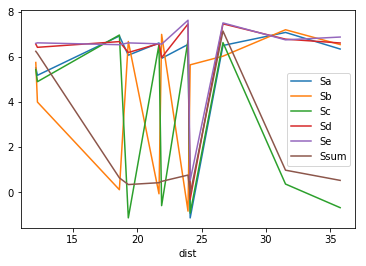

In [108]:
import matplotlib.pyplot as plt
df = wt_diff.drop(columns='i_tree').drop(range(10)).set_index('dist')
df = df.sort_values('dist')
df.plot()

## Check for corelation between well and nearest tree. Busted.

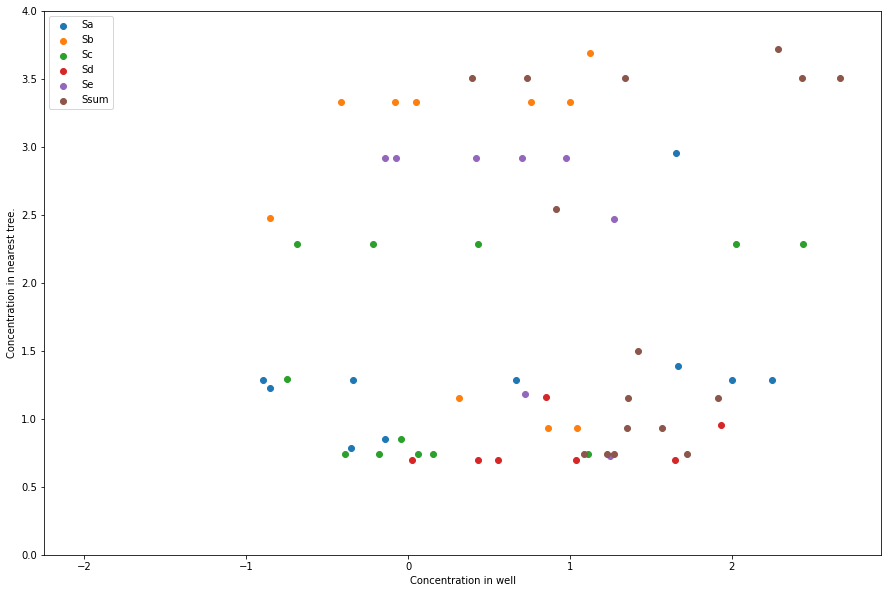

In [109]:
plt.figure(figsize=(15,10))
for i, lbl in enumerate(sum_list):
    X = np.log10(w_df.loc[:, lbl])
    Y = np.log10(trees_i_nb.loc[:, lbl])
    
    plt.scatter(X, Y, label=lbl)
plt.legend()
plt.xlabel('Concentration in well')
plt.ylabel('Concentration in nearest tree.')
plt.ylim(0,4)
plt.show()

## log(well_conc) - log(near_well_conc) for nerest well as function of their distance


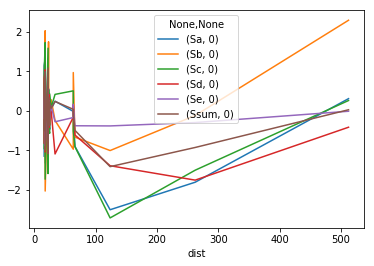

In [110]:
import matplotlib.pyplot as plt
df = ww_diff.set_index('dist')
df = df.sort_values('dist')
df.plot()

## Concentration in trees as function of circumference.

/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


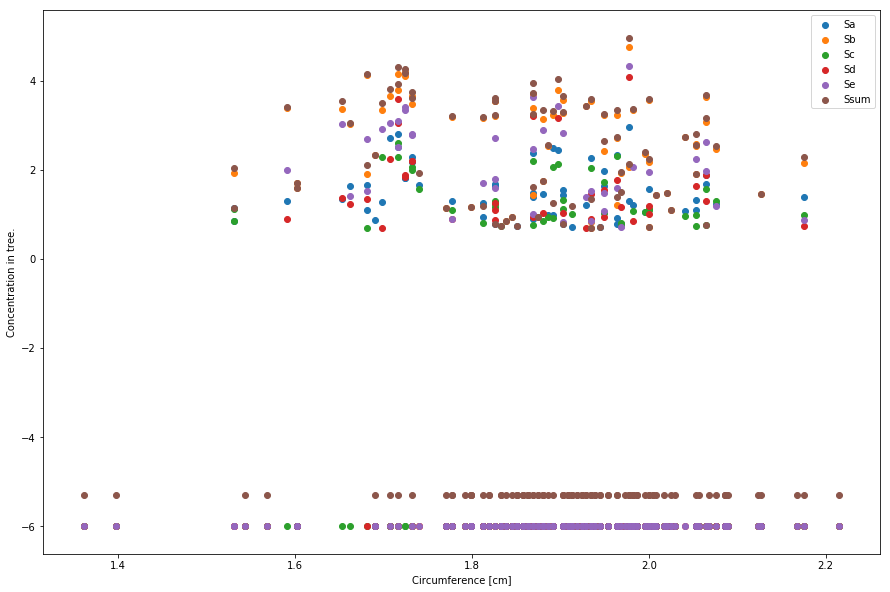

In [111]:
tdf = trees_2018
plt.figure(figsize=(15,10))
for i, lbl in enumerate(sum_list):
    Y = np.log10(tdf.loc[:, lbl])
    X = np.log10(tdf.cfrc)
    
    plt.scatter(X, Y, label=lbl)
plt.legend()
plt.xlabel('Circumference [cm]')
plt.ylabel('Concentration in tree.')
plt.show()

## diff of log for all tree pairs as function of distance

oulayer id: Series([], Name: sid, dtype: object) dist: []


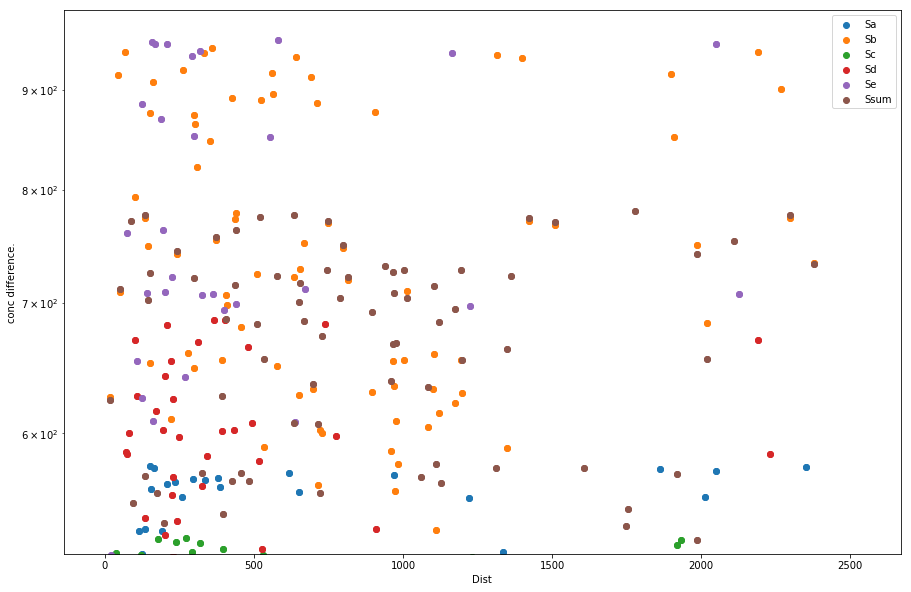

In [113]:
tdf = trees_2017
cx = np.mean(wells_2017.jtsk_x)
cy = np.mean(wells_2017.jtsk_y)
cxy = np.array([cx,cy])
xy = np.stack( (tdf.jtsk_x, tdf.jtsk_y) )

xy = xy.T - cxy
c_dist = np.linalg.norm(xy, axis=1)
ii_far = np.array(c_dist > 10000)
print("oulayer id:", tdf.sid[ii_far], "dist:", c_dist[ii_far])

plt.figure(figsize=(15,10))
dists = np.linalg.norm(xy[: ,None , :] - xy[None, :, :], axis=2)
for i, lbl in enumerate(sum_list):
    #Y = np.log10(tdf.loc[:, lbl])
    Y = tdf.loc[:, lbl]
    flag = np.logical_and(Y > 0.1, Y<1000)
    Y = np.array(Y[flag])
    dist = dists[np.ix_(flag, flag)].flatten()
    #print(dist)
    YY = np.abs( Y[None, :] - Y[:,None] ).flatten()
    #print(len(dist), len(YY))
    plt.scatter(dist, YY, label=lbl)
plt.legend()
plt.xlabel('Dist')
plt.ylabel('conc difference.')
plt.yscale('log')
plt.show()

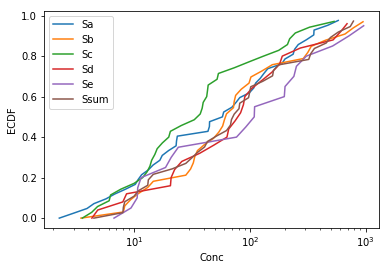

In [92]:
tdf = trees_2017
for i, lbl in enumerate(sum_list):
    Y = tdf.loc[:, lbl].sort_values()
    flag = np.logical_and(Y > 0.1, Y<1000)
    Y = np.array(Y[flag])
    Q = np.arange(len(Y)) / len(Y)
    plt.plot(Y, Q, label=lbl)
plt.legend()
plt.xlabel('Conc')
plt.ylabel('ECDF')
plt.xscale('log')
plt.show()

In [183]:
import pyproj

def make_jtsk(df):
    to_jtsk = pyproj.Proj(init='EPSG:5514')
    jtsk_coords = [ to_jtsk(lo, la) for lo, la in  zip(np.array(df.long), np.array(df.lat)) ]
    x, y = zip(*jtsk_coords)
    df['jtsk_x'] = x
    df['jtsk_y'] = y
    return df

# Test
df = read_table("../2018/June_2018_10_tree_results_fix.xlsx", unit_line=True)
df = make_jtsk(df)
print(df)



FileNotFoundError: [Errno 2] No such file or directory: '../2018/June_2018_10_tree_results_fix.xlsx'

In [ ]:
# Mark river side wood samples
line = np.polyfit([399000,401000],[1070500,1067500],1)
mask = np.polyval(line, df.x) < df.y
df.loc[mask, 'matrix'] = 'wood_river'
df.matrix.unique()

In [ ]:
# Make mask for water samples

#gw_mask = np.logical_or(df.matrix == 'groundwater', df.Stotal == 0)
gw_mask = np.isin(np.array(df.matrix), ['groundwater', 'bc_water'])
water_df = df[gw_mask]
tree_mask = df.matrix == 'wood'
tree_df = df[tree_mask]

mask_zero = water_df['Stotal'] > 2e-6
for name in ['Sa', 'Sb', 'Sc', 'Sd', 'Se']:
    print(name, np.mean(water_df[name][mask_zero]))


In [ ]:
# Plot water conc distribution
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib

log_tot = np.log(np.maximum(1e-6, np.array(tree_df.Sc)))
norm  = mcolors.Normalize(log_tot.min(), log_tot.max())
cmap = matplotlib.cm.get_cmap('plasma')
#norm(water_df.Stotal)
cc1 = cmap(norm(log_tot))

log_tot = np.log(np.maximum(1e-6, np.array(water_df.Sc)))
norm  = mcolors.Normalize(log_tot.min(), log_tot.max())
cmap = matplotlib.cm.get_cmap('plasma')
#norm(water_df.Stotal)
cc2 = cmap(norm(log_tot))

fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


#plt.scatter(list(water_df.x), list(water_df.y), c=list(cc))
ax1.scatter(list(tree_df.x), list(tree_df.y), c=list(cc1))
ax1.plot([399000,401000],[1070500,1067500])
ax2.scatter(list(water_df.x), list(water_df.y), c=list(cc2))
ax2.plot([399000,401000],[1070500,1067500])

plt.show()


In [ ]:
#######################################333
# Setup interpolation points for trees


# m for 1 x unit
x_unit = 0.8
y_unit = 1.0



# quad points for unit circle
step = 0.1
X, Y = np.meshgrid(np.arange(-1,1, step), np.arange(-1,1, step))
X = X.ravel()
Y = Y.ravel()
pts = np.zeros((len(X), 2))
pts[:, 0] = X
pts[:, 1] = Y
r = np.linalg.norm(pts, axis=1)
root_uptake = -(r-1)*(r+1)
mask =  r < 1
pts = pts[mask]
total_uptake = np.sum(root_uptake)
root_uptake = root_uptake[mask]/total_uptake

# make tree grids
tree_grid_df = pd.DataFrame()
# root zone radius [m]
R = 10
Rxy = R / np.array([x_unit, y_unit])
for i, row in tree_df.iterrows():
    tree_grid = pts*Rxy[None, :] + np.array([row.x, row.y])    
    tree_df = pd.DataFrame({ 'x': tree_grid[:,0],      
                          'y': tree_grid[:,1],
                          'id': row.id,
                          'uptake': root_uptake})        
    tree_grid_df = tree_grid_df.append(tree_df, ignore_index=True)

In [ ]:
log_tot = np.array(tree_grid_df.uptake)
norm  = mcolors.Normalize(log_tot.min(), log_tot.max())
cmap = matplotlib.cm.get_cmap('plasma')
#norm(water_df.Stotal)
cc = cmap(norm(log_tot))
plt.scatter(tree_grid_df.x, tree_grid_df.y, c=cc, s=1)
plt.xlim(399000, 399250)
plt.ylim(1067800, 1067900)
plt.show()

In [ ]:
#################################################
# Check interpolation

import scipy.interpolate as interpolate

def interpol_col(col, X, Y):
    log_zero = np.log(1e-6)
    zdata = np.log(np.maximum(1e-6, np.array(water_df[col])))
    xdata = water_df.x
    ydata = water_df.y
    #Z = interpolate.griddata((xdata, ydata), zdata, (X, Y), method='nearest', fill_value=log_zero)
    rb_func = interpolate.Rbf(xdata,ydata,zdata,
                             smooth=0.01)
    Z = rb_func(X,Y)
    return np.exp(Z)

HCH_cols = ['Sa', 'Sb', 'Sc', 'Sd', 'Se', 'Stotal']
fig = plt.figure(figsize=(30,10))
min_x = np.min(water_df.x)
max_x = np.max(water_df.x)
min_y = np.min(water_df.y)
max_y = np.max(water_df.y)
X,Y = np.meshgrid(np.linspace(min_x, max_x, 100), np.linspace(min_y, max_y, 100))
norm = matplotlib.colors.LogNorm(vmin=np.min(1e-6), vmax=np.max(df.Stotal))
for row in range(2):
    for col in range(3):
        col_name = HCH_cols[3*row+col]
        Z = interpol_col(col_name, X.ravel(), Y.ravel())
        ax = fig.add_subplot(2,3,3*row+col+1)
        ax.set_xlabel(col_name)
        img = ax.imshow(Z.reshape(X.shape), 
                  norm=norm,                 
                  extent= (min_x, max_x, min_y, max_y))

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.05])
cbar = plt.colorbar(img, ticks=[1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1], cax=cbar_ax, orientation='horizontal')
#cbar = fig.colorbar(img,  )
#cbar.ax.set_xticklabels(['1Low', 'Medium', 'High'])  # horizontal colorbar        

plt.show()  
        

In [ ]:
###################################
# Interpolate to tree grid
HCH_cols = ['Sa', 'Sb', 'Sc', 'Sd', 'Se']
for col in HCH_cols:
    tree_grid_df[col] = interpol_col(col, tree_grid_df.x, tree_grid_df.y)   

In [ ]:
# compute averages over tree root zone
tree_df = df[df.matrix == 'wood'].copy()
tree_ids = tree_df.id
w_total = np.zeros(len(tree_ids))
for col in HCH_cols:
    values = np.zeros(len(tree_ids))
    for i, t_id in enumerate(tree_ids):
        mask = tree_grid_df['id'] == t_id
        one_tree_df = tree_grid_df[mask]
        values[i] = np.sum(np.array(one_tree_df.uptake)*np.array(one_tree_df[col]))
    w_total += values
    whch = 'W'+col[1]            
    tree_df[whch] = values    

tree_df.loc[:,'Wtotal'] = w_total    
tree_df

In [ ]:
##############################
# Plot interpola
def plot_col(ax, col):
    log_tot = np.log(np.array(tree_df[col]))
    print((log_tot.min(), log_tot.max()))
    norm  = mcolors.Normalize(log_tot.min(), log_tot.max())
    cmap = matplotlib.cm.get_cmap('plasma')
    cc = cmap(norm(log_tot))
    ax.scatter(tree_df.x, tree_df.y, c=cc)

col_table = ['Wa', 'Wb', 'Wc', 'Wd', 'We', 'Wtotal']
fig = plt.figure(figsize=(30,20))
for row in range(2):
    for col in range(3):
        ax = fig.add_subplot(2,3,3*row+col+1)
        plot_col(ax, col_table[3*row+col])
plt.show()        


In [ ]:
import seaborn as sns
# plt.yscale('log')
# plt.xscale('log')
print(tree_df.specie.unique())
print(np.min(np.log(tree_df.Wtotal)), np.max(np.log(tree_df.Wtotal)))
print(np.min(np.log(tree_df.Stotal)), np.max(np.log(tree_df.Stotal)))
mask = tree_df.Stotal > 2e-6
tree_df1 = tree_df[ mask ]
#mask = np.isin(tree_df1.specie, ['oak'])
tree_df2 = tree_df1[ mask ]
#print(tree_df2)

#print(tree_df.specie.value_counts())
tree_df2['log_Wtotal'] = np.log10(tree_df2.loc[:, 'Wtotal'])
tree_df2['log_Stotal'] = np.log10(tree_df2.loc[:, 'Stotal'])



lm = sns.lmplot('log_Wtotal', 'log_Stotal', hue='specie', data=tree_df2, size =15               )
ax = lm.axes
ax[0,0].set_ylim(0,1000)
ax[0,0].set_xlim(0,50)
plt.show()

In [ ]:
tst_df = pd.DataFrame({
    'x': [5,1,2,3],
    'y': [5,4,5,6],
    'c': ['a','b','c','a']
})
plot = sns.lmplot('x', 'y', hue='c', data=tst_df)
plot.set(xscale="log", yscale="log")
plt.show()